In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from typing import Dict, Tuple, Set, Callable


def grouper(input: Dict[Tuple[str, ...],pd.DataFrame],
            keys: Tuple[str, ...]) -> Dict[Tuple[str, ...], pd.DataFrame]:
    """
    Helper function for recursive grouping dict of pandas DataFrames.
    """
    if not keys:
        return input

    to_tuple_transformer: Callable = lambda element: element if isinstance(element, tuple) else (element, )

    grouped_df: Dict[Tuple[str, ...], pd.DataFrame] = {
        (next_key, *to_tuple_transformer(curr_key)): next_df
        for curr_key, curr_df in input.items()
        for next_key, next_df in curr_df.groupby(keys[-1])
    }

    return grouper(grouped_df, keys[:-1])


def group(input: pd.DataFrame,
          keys: Tuple[str, ...] = ("engine_family", "flight_phase")) -> Dict[Tuple[str, ...], pd.DataFrame]:
    """
    Mock function for maintenance characteristics prediction.
    :param input: input DataFrame of aircraft and engine characteristics.
    :param keys: keys that are used for grouping output data.
    :return: output groups of DataFrames of predicted maintenance characteristics.
    """
    phase_df: Dict = {k: v for k, v in input.groupby(keys[-1])}

    return grouper(phase_df, keys[:-1])

In [11]:
X = pd.read_csv('drive/MyDrive/Colab Notebooks/mm/r&d/X.csv')
y = pd.read_csv('drive/MyDrive/Colab Notebooks/mm/r&d/y.csv')

In [21]:
Xcols = set(X.columns)
ycols = set(y.columns)

In [22]:
merged = pd.merge(X, y, on=["engine_id", "flight_datetime", "flight_phase"])

In [23]:
splitted_datasets = group(merged, ("flight_phase", "engine_family"))

In [24]:
def validate(df):
    return df.dropna(axis='columns', thresh=20).dropna()

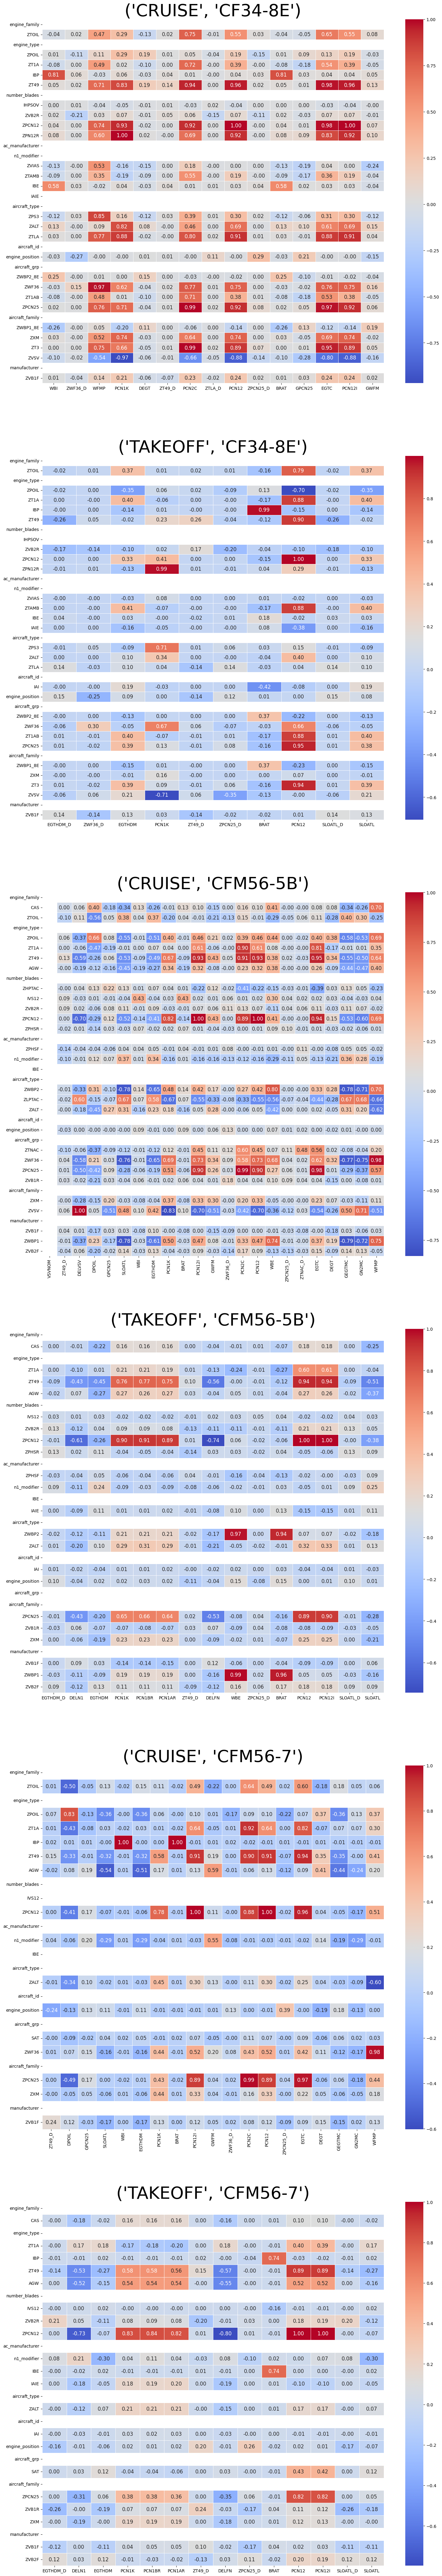

In [42]:
f, ax = plt.subplots(len(splitted_datasets.keys()), 1, figsize=(18, 108))

for i, (key, df) in enumerate(splitted_datasets.items()):
    val_df = validate(df)
    val_df.drop(columns=["engine_id", "flight_datetime", "flight_phase"], inplace=True)
    valdfcols = set(val_df.columns)
    valXcols = list(valdfcols.intersection(Xcols))
    valycols = list(valdfcols.intersection(ycols))
    corr = val_df.corr()[valycols]
    corr = pd.DataFrame(corr, index=valXcols)
    sns.heatmap(corr, annot=True, annot_kws={'size': 12}, linewidths=.5, fmt= '.2f', cmap="coolwarm", ax=ax[i])
    ax[i].set_title(str(key), fontsize=40)
plt.show()